<a href="https://colab.research.google.com/github/rahulsm27/ML/blob/main/DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.utils.data
from torchvision import datasets, transforms
import numpy as np
import pandas as pd

from torch import nn, optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [46]:
from torch.utils.data import DataLoader


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0,1)])
# Load the MNIST dataset
mnist_dataset_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Load the test MNIST dataset
mnist_dataset_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


batch_size = 128
train_loader = torch.utils.data.DataLoader(mnist_dataset_train,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_dataset_test,batch_size=5, shuffle=False)


In [3]:
latent_dim = 64
categorical_dim = 2



In [9]:
class DAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)

        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
      # Add noise to the images
      #  noise_factor = 0.5
      #  x_noise = x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape)

#        self.noise = torch.randn(x.shape)
 #       x_noise = x + self.noise
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return self.relu(self.fc3(h2))

    def decode(self, z):
        h4 = self.relu(self.fc4(z))
        h5 = self.relu(self.fc5(h4))
        return self.sigmoid(self.fc6(h5))

    def forward(self, x):
        q = self.encode(x.view(-1, 784))
        #print (q.size)
      #  q_y = q.view(q.size(0), latent_dim, categorical_dim)
        return self.decode(q)

In [10]:
# # Reconstruction + KL divergence losses summed over all elements and batch
# def loss_function(recon_x, x, qy):
#     BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False) / x.shape[0]

#     log_ratio = torch.log(qy * categorical_dim + 1e-20)
#     KLD = torch.sum(qy * log_ratio, dim=-1).mean()

#     return BCE + KLD

In [17]:

def train(epoch, model, train_loader, optimizer,  cuda=True):
  model.train()
  train_loss = 0
  for batch_idx, (data, _) in enumerate(train_loader):
    data.to(device)
    optimizer.zero_grad()

    data_noise = torch.randn(data.shape).to(device)
    data_noise = data + data_noise

    recon_batch = model(data_noise.to(device))
    loss = criterion(recon_batch, data.view(data.size(0),-1).to(device) )
    loss.backward()

    train_loss += loss.item() * len(data)
    optimizer.step()


    if batch_idx % 100 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader),
                  loss.item()))

  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [18]:
epochs = 10

model = DAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()


In [19]:
for epoch in range(1, epochs + 1):
    train(epoch, model, train_loader, optimizer, True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.231181
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.062519
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.052696
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.046211
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.046429
====> Epoch: 1 Average loss: 0.0569
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.042644
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.040647
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.041334
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.041501
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.041782
====> Epoch: 2 Average loss: 0.0415
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.039998
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.041541
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.040298
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.040134
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.039351
====> Epoch: 3 Average loss: 0.0398
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.039334
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.040072
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.039271
Train Epoch:

 Image 0 with label 7               Image 1 with label 2               Image 2 with label 1               Image 3 with label 0               Image 4 with label 4              

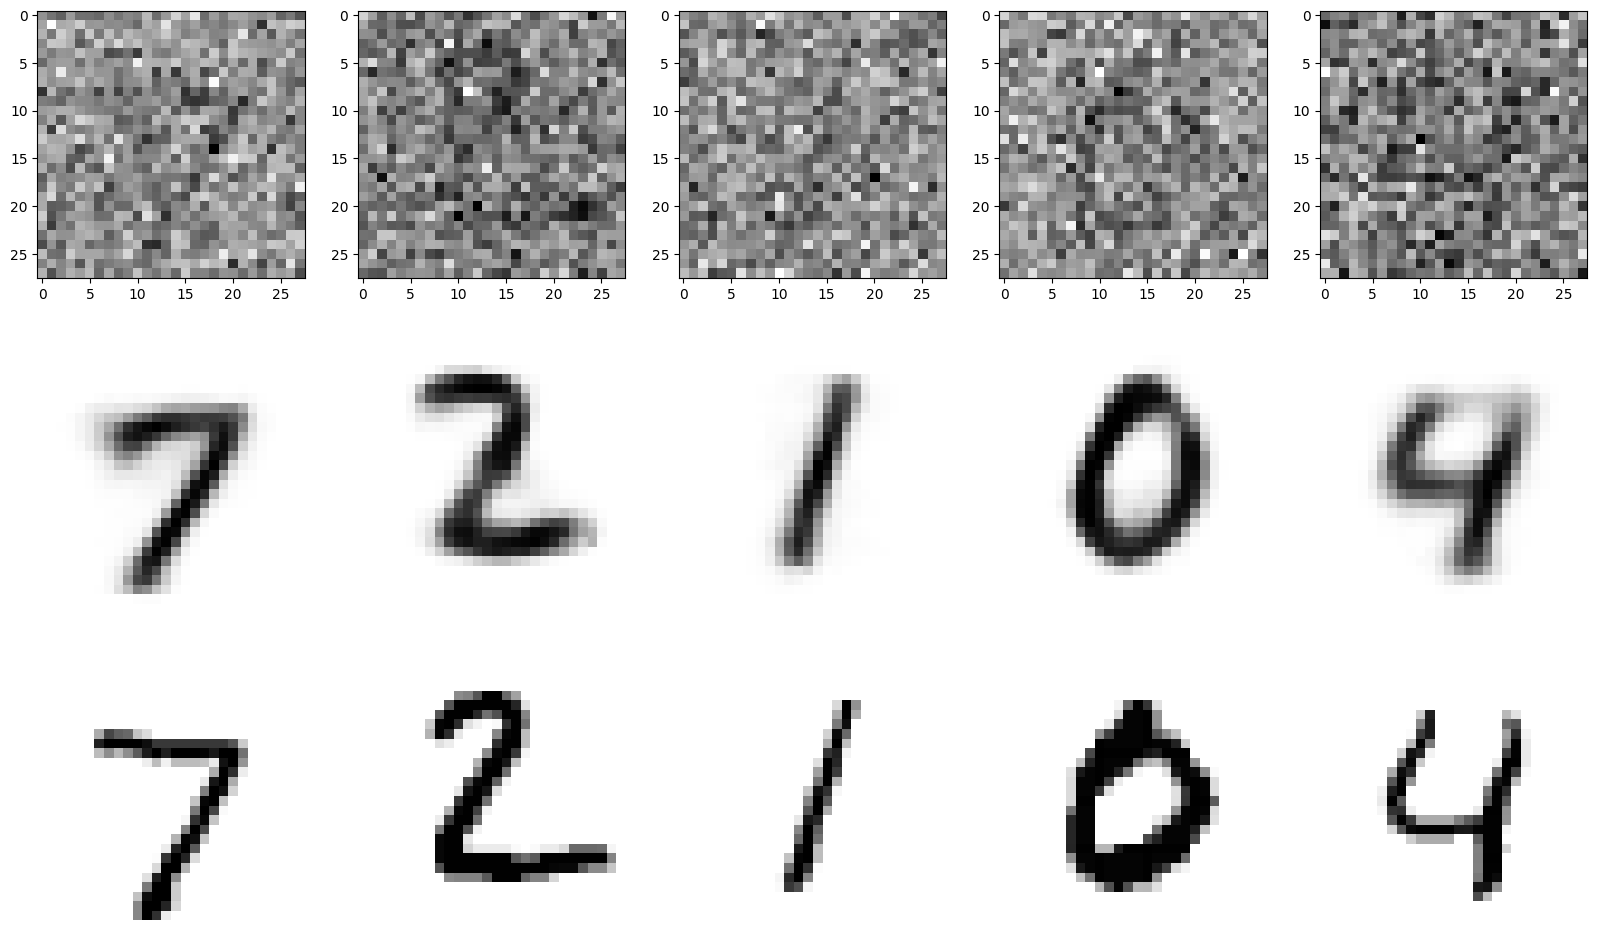

In [55]:
import matplotlib.pyplot as plt
for batch_idx, (data, labels) in enumerate(test_loader):
    data.to(device)
    optimizer.zero_grad()

    data_noise = torch.randn(data.shape).to(device)
    data_noise = data + data_noise

    recon_batch = model(data_noise.to(device))
    break


plt.figure(figsize=(20,12))
for i in range(5):

    print(f" Image {i} with label {labels[i]}              " , end = "")
    plt.subplot(3,5,1+i)
    plt.imshow(data_noise[i,:,:,:].view(28,28).detach().numpy(), cmap='binary')
    plt.subplot(3,5,6+i)
    plt.imshow(recon_batch[i,:].view(28,28).detach().numpy(), cmap='binary')
    plt.axis('off')
    plt.subplot(3,5,11+i)
    plt.imshow(data[i,:,:,:].view(28,28).detach().numpy(), cmap='binary')
    plt.axis('off')
plt.show()

In [50]:
len(train_loader) * 128

60032

In [51]:
len(test_loader) * 5

10000

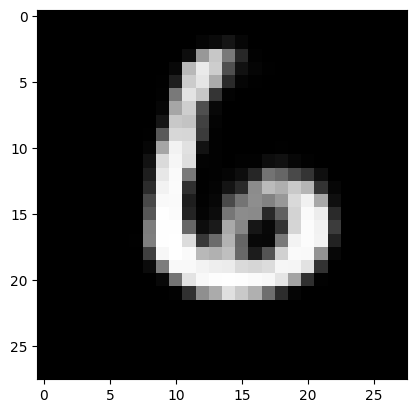

In [ ]:
import matplotlib.pyplot as plt





x_test = torch.randn(128).to(device)
denoised_images = model.decode(x_test)*255
# Display the first image in the denoised test set
plt.imshow(denoised_images.view(28,28).detach().numpy(), cmap='gray')
plt.show()

In [26]:
# Load the test MNIST dataset
mnist_dataset_test[1][0].size()

torch.Size([1, 28, 28])

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load California housing dataset
california_housing = fetch_california_housing()
X, y = california_housing.data, california_housing.target

# Expand dimensions of y to make it two-dimensional
y = y.reshape(-1, 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a RandomForestRegressor for multioutput regression
regressor_multioutput = MultiOutputRegressor(RandomForestRegressor())

# Train the model
regressor_multioutput.fit(X_train, y_train)

# Make predictions
predictions_multioutput = regressor_multioutput.predict(X_test)

# Evaluate mean squared error for multioutput regression
mse_multioutput = mean_squared_error(y_test, predictions_multioutput)
print("Multioutput Regression Mean Squared Error: {}".format(mse_multioutput))



Multioutput Regression Mean Squared Error: 0.2549214725718225


In [ ]:
predictions_multioutput

array([[0.50198  ],
       [0.74939  ],
       [4.7979261],
       ...,
       [4.8813893],
       [0.69799  ],
       [1.69419  ]])

In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
# Step 2: Load and explore the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

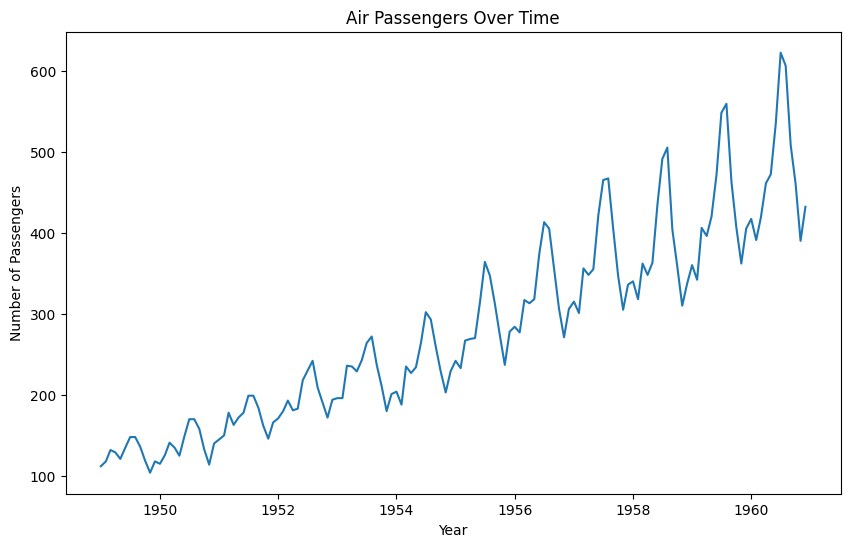

In [ ]:
# Visualize the data
plt.figure(figsize=(10, 6))
plt.plot(data)
plt.title('Air Passengers Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

In [ ]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [ ]:
# Fit ARIMA model
order = (2, 1, 2)  # (p, d, q) values, determined through analysis
model = ARIMA(train, order=order)
fit_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# Forecast future values
forecast_steps = len(test) + 12  # Adjust the number of steps as needed
forecast = fit_model.get_forecast(steps=forecast_steps)

In [ ]:
# Evaluate performance
mse = mean_squared_error(test, forecast.predicted_mean)
print(f'Mean Squared Error: {mse}')

ValueError: Found input variables with inconsistent numbers of samples: [29, 41]

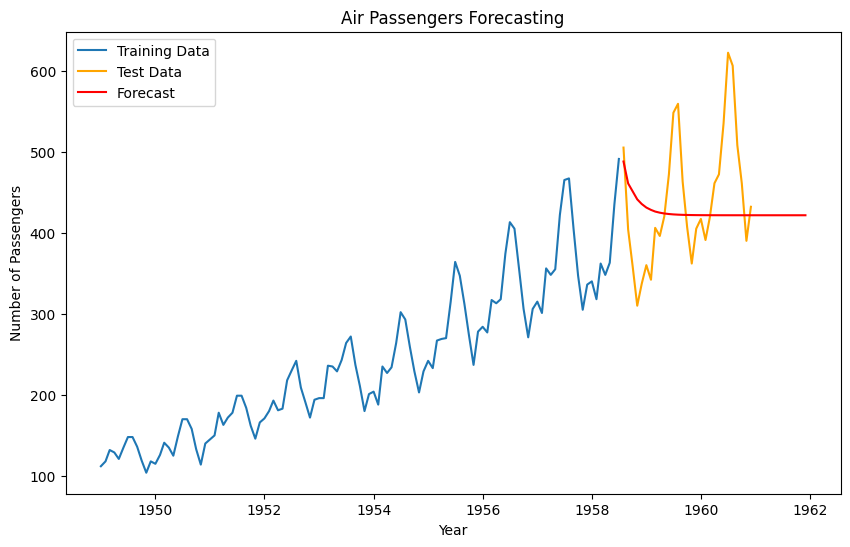

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data', color='orange')
plt.plot(forecast.predicted_mean, color='red', label='Forecast')
plt.title('Air Passengers Forecasting')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


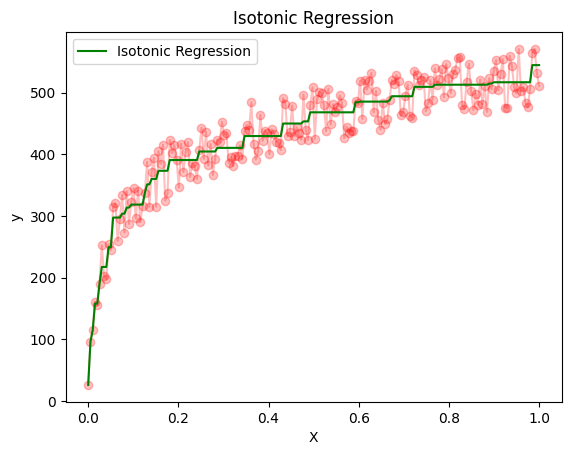

In [ ]:
#Importing Necessary library
import numpy as np
import matplotlib.pyplot as plt
from sklearn import isotonic

# creating dataset for training
n=200
noise=np.random.randint(0,1e2,size=(n,))
x_train=np.linspace(0,1,n)
y_train=90*np.log1p(np.arange(n)) + noise

# training using isotonic regression model
reg=isotonic.IsotonicRegression(increasing=True)
reg.fit(x_train,y_train)

#calculating the predicted value
y_iso_pred=reg.predict(x_train)

#plotting the graph
plt.plot(x_train,y_train,marker='o',color='r',alpha=0.25)
plt.plot(x_train, y_iso_pred, color='g', label='Isotonic Regression')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Isotonic Regression')
plt.show()

In [ ]:
# Install scikit-learn if not already installed
# !pip install scikit-learn

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the Wine Quality dataset
wine_data = pd.read_csv("winequality.csv")

# Separate independent variables (X) and dependent variable (y)
X = wine_data.drop("quality", axis=1)
y = wine_data["quality"]

# Data scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize PLS model with the desired number of components
pls_model = PLSRegression(n_components=3)

# Fit the model on the training data
pls_model.fit(X_train, y_train)

# Predictions on the test set
y_pred = pls_model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Visualize predicted vs actual values
plt.scatter(y_test, y_pred, label='Actual vs Predicted', alpha=0.7)
plt.scatter(y_test, y_test, label='Actual vs Actual', alpha=0.7, color='red')  # Different color for actual values
plt.xlabel("Actual Wine Quality")
plt.ylabel("Wine Quality Prediction")
plt.title("PLS Regression: Actual vs Predicted Wine Quality")
plt.legend()
plt.show()

ValueError: could not convert string to float: 'white'

In [ ]:
import numpy as np

class RBM:
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.weights = np.random.randn(num_visible, num_hidden)
        self.visible_bias = np.zeros(num_visible)
        self.hidden_bias = np.zeros(num_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def gibbs_sampling(self, visible_data, k=1):
        for _ in range(k):
            hidden_probs = self.sigmoid(np.dot(visible_data, self.weights) + self.hidden_bias)
            hidden_states = np.random.rand(len(visible_data), self.num_hidden) < hidden_probs
            visible_probs = self.sigmoid(np.dot(hidden_states, self.weights.T) + self.visible_bias)
            visible_data = np.random.rand(len(visible_data), self.num_visible) < visible_probs
        return visible_data, hidden_probs

    def contrastive_divergence(self, data, learning_rate=0.1, k=1, epochs=10):
        for _ in range(epochs):
            positive_hidden_probs = self.sigmoid(np.dot(data, self.weights) + self.hidden_bias)
            positive_hidden_states = np.random.rand(len(data), self.num_hidden) < positive_hidden_probs
            positive_associations = np.dot(data.T, positive_hidden_probs)

            recon_data, recon_hidden_probs = self.gibbs_sampling(data, k)
            negative_visible_probs = recon_data
            negative_hidden_probs = recon_hidden_probs
            negative_associations = np.dot(recon_data.T, negative_hidden_probs)

            self.weights += learning_rate * (positive_associations - negative_associations)
            self.visible_bias += learning_rate * np.mean(data - negative_visible_probs, axis=0)
            self.hidden_bias += learning_rate * np.mean(positive_hidden_probs - negative_hidden_probs, axis=0)

# Example usage
np.random.seed(42)  # For reproducibility
num_visible = 6
num_hidden = 3
data = np.random.rand(100, num_visible)  # Sample data (replace this with your own dataset)

rbm = RBM(num_visible, num_hidden)
rbm.contrastive_divergence(data)

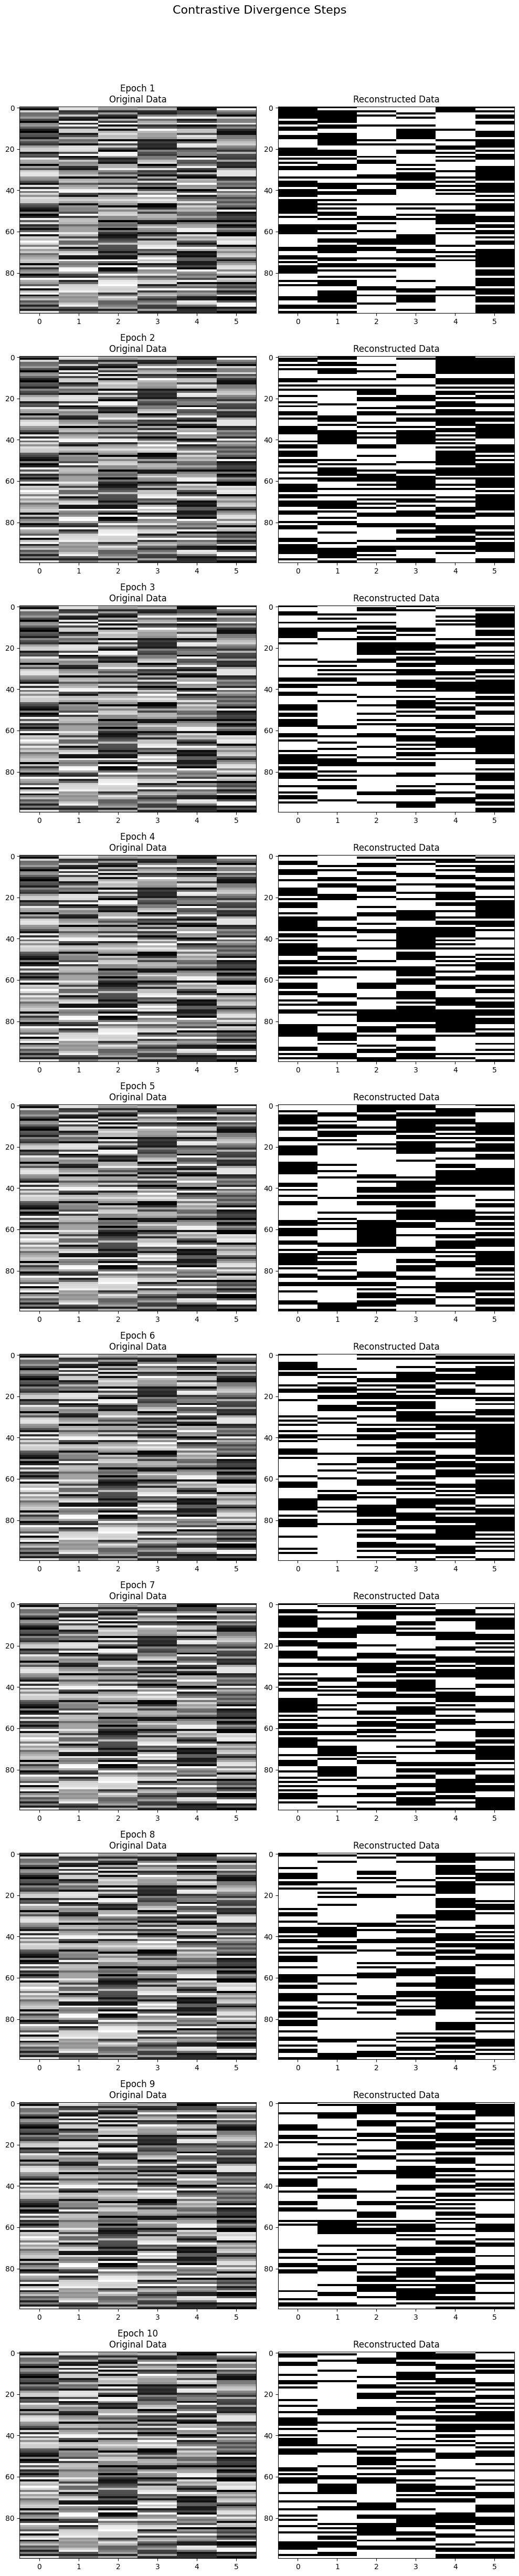

In [ ]:
import matplotlib.pyplot as plt

def visualize_cd_steps(rbm, data, num_epochs=10, k=1):
    fig, axs = plt.subplots(nrows=num_epochs, ncols=2, figsize=(10, 5 * num_epochs))
    fig.suptitle('Contrastive Divergence Steps', fontsize=16)

    for epoch in range(num_epochs):
        # Positive phase (original data)
        positive_hidden_probs = rbm.sigmoid(np.dot(data, rbm.weights) + rbm.hidden_bias)
        positive_hidden_states = np.random.rand(len(data), rbm.num_hidden) < positive_hidden_probs
        recon_data, recon_hidden_probs = rbm.gibbs_sampling(data, k)

        # Plot original data and reconstruction
        axs[epoch, 0].imshow(data, cmap='gray', aspect='auto')
        axs[epoch, 0].set_title(f'Epoch {epoch + 1}\nOriginal Data')
        axs[epoch, 1].imshow(recon_data, cmap='gray', aspect='auto')
        axs[epoch, 1].set_title(f'Reconstructed Data')

        # Update RBM parameters
        rbm.contrastive_divergence(data)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage
np.random.seed(42)  # For reproducibility
num_visible = 6
num_hidden = 3
data = np.random.rand(100, num_visible)  # Sample data (replace this with your own dataset)

rbm = RBM(num_visible, num_hidden)
visualize_cd_steps(rbm, data, num_epochs=10, k=1)
